## Data Visualization of Kiva NGO data

[Kiva.org](https://www.kiva.org/) is an online crowdfunding platform to extend financial services to poor and financially excluded people around the world by accepting donations online. Anybody of us can donate $ 1, $ 100 or $ 10000 sitting at home.

**Aim** of this analysis is: Use Data Visualization to locate those regions which need to be prioritized for funding because they are more economically backward than other regions. Kiva provided loan & region data, finding appropriate economical and financial data & connecting it to the loan & region data was a **part of the problem**

Summary of my approach:

1. I started with initial EDA of various information in the dataset
2. Phillipines was the country which had most of the loans so I decided to focus on it
3. Found some economic indicators for Philippines
4. Data **lot of data cleaning** to connect the external data and loan data
5. Used the combined data to locate a few regions where loan flow can be prioritized due to poverty

Tools used: R, ggplot2 and other miscellaneous helper packages for data visualization

## Notebook 3 - Prioritizing regions in Philippines

* load internal data
* load external data
* Do data cleaning and bring the internal and external region encodings in the same format
* Join the two datasets
* Compare loan characteristics and economic characteristics
* Give suggestions

## Phillipines

Some poverty data


Philippines has the highest amount of loans in our data. I found an interesting website providing miscellaneous statistics on philippines. Following is the [link](http://countrystat.psa.gov.ph/) to it

* **The following code**


1. Reads 3 external files. one for sub-regions (provinces), one for regions and another one for poverty indicators.



2. Joins this with kiva_loans_philp (subset of kiva_loans containing Philippines data)

In [3]:
# supress warnings globally
options(warn=-1)

library(ggplot2)
library(dplyr)
library(repr)
library(corrplot)
library(gridExtra)

kiva_loans <- read.csv("kiva_loans.csv", header=T)
kiva_regions <- read.csv("kiva_mpi_region_locations.csv", header=T)

philp_loans <- kiva_loans %>% filter(country == "Philippines")
philp_regions <- kiva_regions %>% filter(country == "Philippines")
vec <- c()
philp_loans$loan_region <- as.character(philp_loans$region)
for(i in 1:nrow(philp_loans)){
    vec <- append(vec, sub('.*,\\s*','', philp_loans$loan_region[i]))
}

philp_loans$sub_region <- vec
#philp_loans %>% group_by(sub_region) %>% summarise(count = n()/160441) %>% arrange(desc(count))


# region files reading and internal joins to form 1 file from 2 files

province = read.csv("philippines_province.csv", header=T)
region = read.csv("philippines_region.csv", header=T)

philippines_regions <- inner_join(province, region, by = "regCode")
philippines_regions$X <- NULL


# Join philip_loans to philippines_regions on "sub_region" == "provDesc"
# Changing name of provDesc to sub_region in the Philippines_regions file
names(philippines_regions)[3] <- "sub_region"

# Left joining to keep all the philip_loans (NAs whereever loan region has no match with external regions file)
philp_loans_new <- left_join(philp_loans, philippines_regions, by = "sub_region")
#prop.table(table(is.na(philp_loans_new$regDesc)))
# currently missing ~ 17% values

# importing poverty indicators per region data
philp_poverty_indicators <- read.csv("consolidated_philippines_poverty_data.csv", header=T)

rm(philp_loans)
philp_loans <- left_join(philp_loans_new, philp_poverty_indicators, by = "regDesc")


rm(philp_loans_new)

philp_loans_new <- philp_loans %>% select(-id.x, -id.y, -psgcCode.y, -psgcCode.x)

* Now we have a data which has loans information in certain regions in Philippines as well as some poverty indicators in those regions.




* Lets explore the new data we have got



* A look at LOANS and POVERTY combined data

In [4]:
head(philp_loans_new,3)

id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,agr_wage_farm_workers_allgender_2015,agr_wage_farm_workers_male_2015,agr_wage_farm_workers_female_2015,avg_annual_total_incm_farm_households_02_03,avg_annual_farm_incm_farm_households_02_03,avg_annual_off_farm_incm_farm_households_02_03,avg_annual_non_farm_incm_farm_households_02_03,avg_annual_other_sources_incm_farm_households_02_03,avg_rural_income_2000,total_emply_2016
653092,175,175,Pigs,Agriculture,to buy piglets and feed,PH,Philippines,Liloy-Dela Paz,PHP,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
653149,175,175,Pigs,Agriculture,to purchase feed and vitamins for her pigs,PH,Philippines,"Tanjay, Negros Oriental",PHP,...,156.17,160.65,150.67,72177,28074,5574,31055,7474,68447,3234
653123,700,700,General Store,Retail,"to buy additional items like eggs, charcoal, rice, Milo, shampoo, groceries, etc. to sell",PH,Philippines,"Brookes Point, Palawan",PHP,...,188.73,192.16,170.73,126237,74702,6579,35262,9694,NA,1252


* **We can see that we are missing a lot of data. We are missing the data for the rows which did not find a region match with the external data.**


* **Lets see how many % of the rows we have compromised** *

In [5]:
cat("The proportion of REGION join matches missing due to a bit of unclean data are")
prop.table(table(is.na(philp_loans_new$regDesc)))

The proportion of REGION join matches missing due to a bit of unclean data are


    FALSE      TRUE 
0.8237171 0.1762829 

* We are missing new region values for **17.6%** Philippines loans.



* Lets delete these rows for further analysis.

In [6]:
completeFun <- function(data, desiredCols) {
  completeVec <- complete.cases(data[, desiredCols])
  return(data[completeVec, ])
}

philp_data <- completeFun(philp_loans_new, "regDesc")

* Now let us dig deep into the FEMALE-AGRICULTURE segment in Philippines



* Correlations of different poverty metrics and loan features using 'corrplot' package



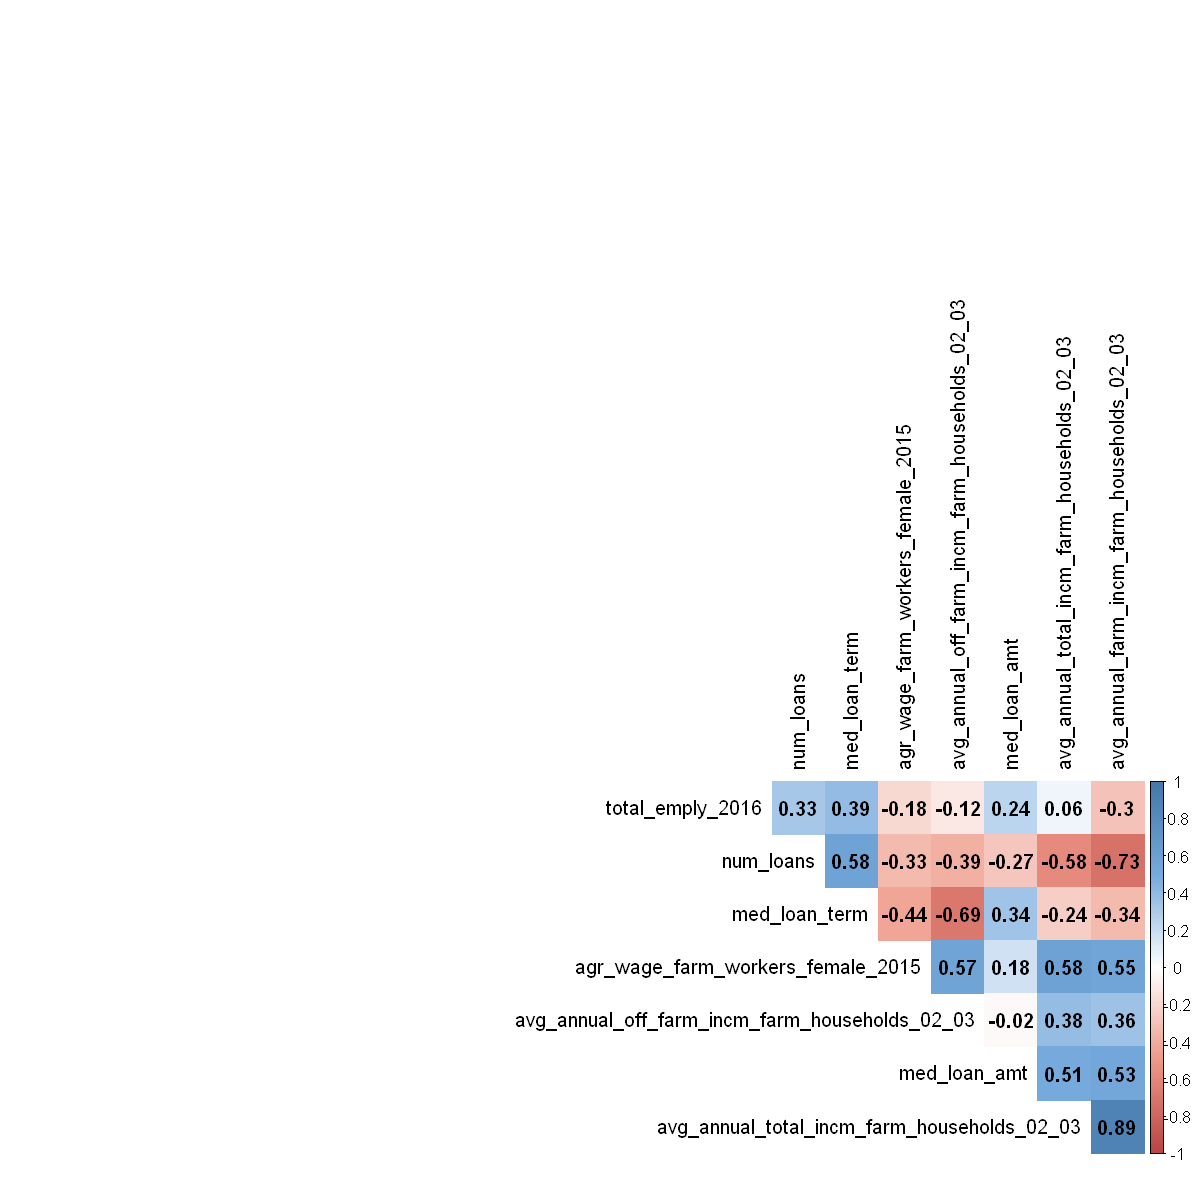

In [28]:
philp_data$gender <- if_else((philp_data$borrower_genders == "male"), "male","female")

# Segment: Female-Agriculture


female_agr_summary <- philp_data %>% filter(gender == "female" & sector == "Agriculture") %>%
         group_by(regDesc) %>% summarise(num_loans = n_distinct(id),
                                            med_loan_amt = median(loan_amount),
                                            med_loan_term = median(term_in_months),
                                              agr_wage_farm_workers_female_2015 = mean(agr_wage_farm_workers_female_2015),
                                              avg_annual_total_incm_farm_households_02_03 = mean(avg_annual_total_incm_farm_households_02_03),
                                              avg_annual_farm_incm_farm_households_02_03 = mean(avg_annual_farm_incm_farm_households_02_03),
                                              avg_annual_off_farm_incm_farm_households_02_03 = mean(avg_annual_off_farm_incm_farm_households_02_03),
                                              avg_rural_income_2000 = mean(avg_rural_income_2000),
                                              total_emply_2016 = mean(total_emply_2016))

corr_1 = cor(female_agr_summary[,c(2:8,10)])

col <- colorRampPalette(c("#BB4444", "#EE9988", "#FFFFFF", "#77AADD", "#4477AA"))

options(repr.plot.width=10, repr.plot.height=10)

corrplot(corr_1, method="color", col=col(200),  
         type="upper", order="hclust", 
         addCoef.col = "black", # Add coefficient of correlation
         tl.col="black", tl.srt=90, #Text label color and rotation
         # Combine with significance
          sig.level = 0.01, insig = "blank", 
         # hide correlation coefficient on the principal diagonal
         diag=FALSE 
         )

options(repr.plot.width=7, repr.plot.height=7)

* **Following are the variables**

1) agr_wage_farm_workers_allgender_2015 - Agriculture Wage Rates of Farm Workers (All Gender) in 2015 - UNIT: pesos

2) agr_wage_farm_workers_male_2015 - Similar to above for males - UNIT: pesos

3) agr_wage_farm_workers_female_2015 - Similar to above for females - UNIT: pesos

4) avg_annual_total_incm_farm_households_02_03 - Average annual total income for farm households Year 2002-03 - UNIT: pesos

5) avg_annual_farm_incm_farm_households_02_03 - Average annual total income for farm households Year 2002-03 - UNIT: pesos

6) avg_annual_off_farm_incm_farm_households_02_03 - Average annual total income for farm households Year 2002-03 - UNIT: pesos

7) avg_annual_non_farm_incm_farm_households_02_03 - Average annual total income for farm households Year 2002-03 - UNIT: pesos

8) avg_annual_other_sources_incm_farm_households_02_03 - Average annual total income for farm households Year 2002-03 - UNIT: pesos

9) avg_rural_income_2000 - Average rural income - UNIT: pesos

10) total_emply_2016 - Total employment 2016 - UNIT: thousand persons


* We can see **Number of loans & Loan terms have negative correlation with all the income variables** implying as the number of loans and/or loan_terms in a region go up, the income indicators are coming down. This is intuitive in a sense that poor people are the ones who take more and longer loans.


* **Median loan amount on the other hand as positive correlation with most of the income indicators** implying that as the median loan amount goes up in a region, the income indicators are seen to be on an increase as well. This is also intuitive.



* **The negative correlation of number of loans with farm income is more in magnitude than total income or off farm income in farm households**. So KIVA can also prioritize loans based on different incomes of a particular person. If lets say a female is a farmer in a poor area with a very low farm income, then the loan to that female can be prioritized over a loan request of a female in a rich area having more farm income.


#### Q) Which region is the poorest w.r.t the income indicators we have?

TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]

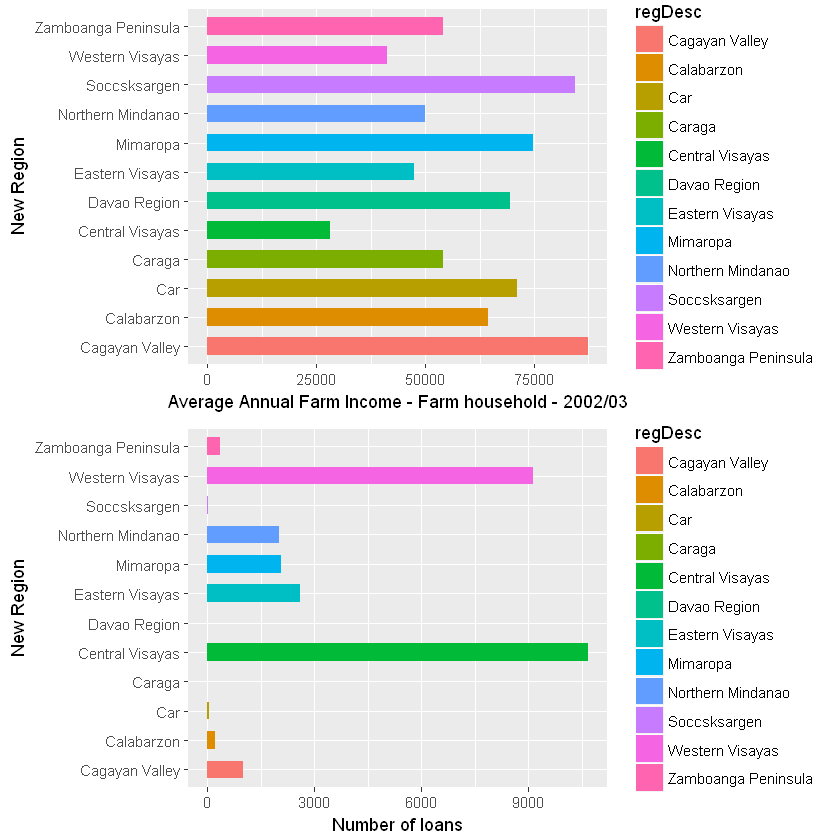

In [31]:
plt_5 <- ggplot(data = female_agr_summary,
       aes(x = regDesc, y = avg_annual_farm_incm_farm_households_02_03)) +
  geom_bar(aes(fill = regDesc), stat = "identity", width = 0.6) +
  scale_x_discrete("New Region") + scale_y_continuous("Average Annual Farm Income - Farm household - 2002/03") +
  #ggtitle("Top 10 activities for females in top 5 countries") +
    coord_flip() + theme_grey()

plt_6 <- ggplot(data = female_agr_summary,
       aes(x = regDesc, y = num_loans)) +
  geom_bar(aes(fill = regDesc),stat = "identity", width = 0.6) +
  scale_x_discrete("New Region") + scale_y_continuous("Number of loans") +
  #ggtitle("Top 10 activities for females in top 5 countries") +
 coord_flip() + theme_grey()

grid_1 <- grid.arrange(plt_5, plt_6, nrow = 2, ncol=1)
grid_1

* Among this segment (Female-Agriculture), **loans should be prioritized in CENTRAL & WESTERN VISAYAS regions because clearly they are not doing too good with respect to Average Annual Farm Income** metrics in pesos and are also taking **high number of loans** indicating a more needy section of people inhabiting in these regions.



* Agriculture females in regions like **Soccsksargen, Cagayan Valley, Davao, CAR** take less loans or rather their might be less population from this segment their in the first place. These regions where the loans are less do well though with respect to Farm incomes. So Farming/Agriculture families staying in these places can be assumed to be richer.

TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]

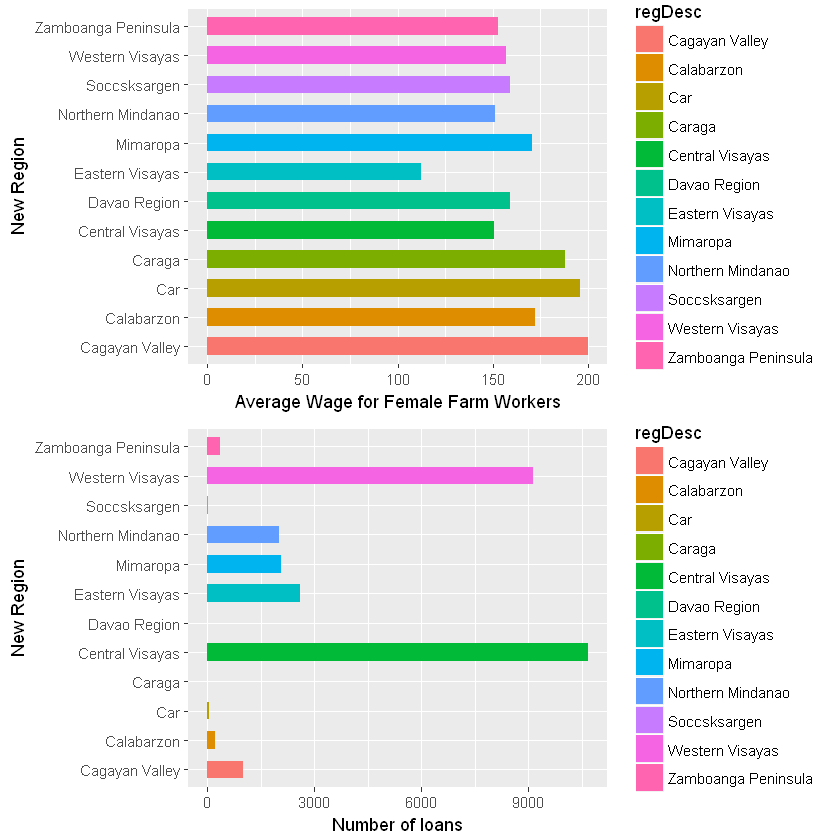

In [32]:
plt_7 <- ggplot(data = female_agr_summary,
       aes(x = regDesc, y = agr_wage_farm_workers_female_2015)) +
  geom_bar(aes(fill = regDesc), stat = "identity", width = 0.6) +
  scale_x_discrete("New Region") + scale_y_continuous("Average Wage for Female Farm Workers") +
  #ggtitle("Top 10 activities for females in top 5 countries") +
    coord_flip() + theme_grey()

plt_8 <- ggplot(data = female_agr_summary,
       aes(x = regDesc, y = num_loans)) +
  geom_bar(aes(fill = regDesc),stat = "identity", width = 0.6) +
  scale_x_discrete("New Region") + scale_y_continuous("Number of loans") +
  #ggtitle("Top 10 activities for females in top 5 countries") +
 coord_flip() + theme_grey()

grid_1 <- grid.arrange(plt_7, plt_8, nrow = 2, ncol=1)
grid_1

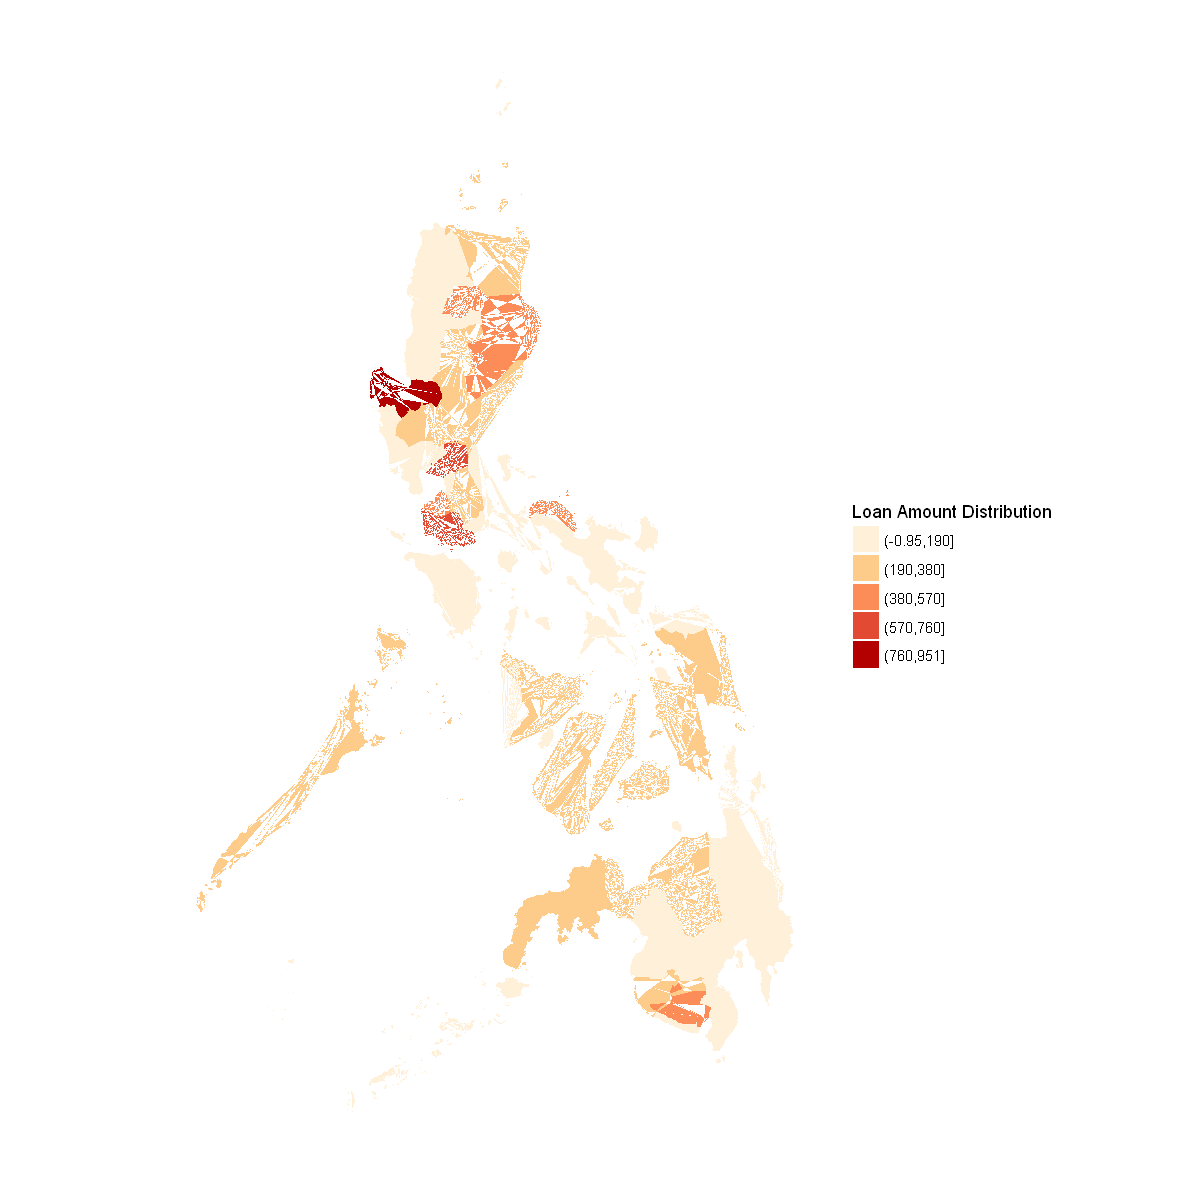

In [34]:
library(ggplot2)
library(rgdal)
library(maptools)
library(rgeos)
library(dplyr)

ph.adm1.spdf <- readRDS("PHL_adm2.rds")
ph.adm1.df <- fortify(ph.adm1.spdf, region = "NAME_1")

phadmunique = unique(ph.adm1.df$id)
subregunique = unique(philp_loans$sub_region)
common_regions = intersect(phadmunique, subregunique)

gb_loan_amt_ph <-  philp_loans %>% 
      filter(sub_region %in% common_regions) %>%
        group_by(sub_region) %>% summarise(loan_amt_median = median(loan_amount))

gb_loan_amt_ph <- data.frame(gb_loan_amt_ph)
names(gb_loan_amt_ph)[1] = "id"

ph.adm1.df <- merge(ph.adm1.df, gb_loan_amt_ph, by.y = 'id', all.x = TRUE)
ph.adm1.df$loan_amt_median[is.na(ph.adm1.df$loan_amt_median)] <- 0

ph.adm1.centroids.df <- data.frame(long = coordinates(ph.adm1.spdf)[, 1], 
                                   lat = coordinates(ph.adm1.spdf)[, 2]) 

# Get names and id numbers corresponding to administrative areas
ph.adm1.centroids.df[, 'ID_1'] <- ph.adm1.spdf@data[,'ID_1']
ph.adm1.centroids.df[, 'NAME_1'] <- ph.adm1.spdf@data[,'NAME_1']


options(repr.plot.width=10, repr.plot.height=10)
p <- ggplot(ph.adm1.df, aes(x = long, y = lat, group = group)) + geom_polygon(aes(fill = cut(loan_amt_median,5))) +
 # geom_text(data = ph.adm1.centroids.df, aes(label = NAME_1, x = long, y = lat, group = NAME_1), size = 1) + 
  labs(x=" ", y=" ") + 
  theme_bw() + scale_fill_brewer('Loan Amount Distribution', palette  = 'OrRd') + 
  coord_map() + 
  theme(panel.grid.minor=element_blank(), panel.grid.major=element_blank()) + 
  theme(axis.ticks = element_blank(), axis.text.x = element_blank(), axis.text.y = element_blank()) + 
  theme(panel.border = element_blank())

print(p)